In [3]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../')
from apnet.model import APNet
from dcase_models.data.datasets import UrbanSound8k
from dcase_models.data.dataset_base import Dataset
from dcase_models.data.features import MelSpectrogram
from dcase_models.util.files import load_json, mkdir_if_not_exists
from dcase_models.util.files import load_pickle, save_pickle
from dcase_models.data.data_generator import DataGenerator
from dcase_models.data.data_augmentation import AugmentedDataset
from dcase_models.data.scaler import Scaler
from apnet.layers import PrototypeLayer, WeightedSum
from dcase_models.util.data import evaluation_setup

from dcase_models.util.files import mkdir_if_not_exists, list_wav_files

from sklearn import linear_model
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


os.environ["CUDA_VISIBLE_DEVICES"] = "1"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
dataset_name = 'UrbanSound8k'
model_name = 'APNet'
features_name = 'MelSpectrogram'
fold_name = 'fold10'

In [6]:
# Get parameters
exp_path = '../experiments'
model_folder = os.path.join(exp_path, dataset_name, model_name)
parameters_file = os.path.join(model_folder, 'config.json')
params = load_json(parameters_file)
params_dataset = params['datasets'][dataset_name]
params_features = params['features'][features_name]
params_model = params['models']['APNet']

In [7]:
dataset_path = os.path.join(exp_path, params_dataset['dataset_path'])
dataset = UrbanSound8k(dataset_path)
dataset.check_if_downloaded()

True

In [9]:
features = MelSpectrogram(**params_features)
print(features.get_shape())
if not features.check_if_extracted(dataset):
    features.extract(dataset)

(1, 84, 128)
[############################################################] 8732/8732


In [10]:
exp_folder = os.path.join(model_folder, fold_name)
scaler = load_pickle(os.path.join(exp_folder, 'scaler.pickle'))

model_container = APNet(
    model=None, model_path=exp_folder, 
    custom_objects={
        'PrototypeLayer': PrototypeLayer,
        'WeightedSum': WeightedSum
    },
    **params['models']['APNet']['model_arguments']
)
model_container.load_model_weights(exp_folder)
model_container.model.summary()

(50, 32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 84, 128)      0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 21, 32, 32), 52096       input[0][0]                      
__________________________________________________________________________________________________
features (Lambda)               (None, 21, 32, 32)   0           encoder[1][0]                    
__________________________________________________________________________________________________
prototype_distances (PrototypeL (None, 50, 32)       1075200     features[0][0]                   
__________________________________________________________________________________________________
s

In [11]:
folds_train, folds_val, _ = evaluation_setup(
    fold_name, dataset.fold_list,
    params_dataset['evaluation_mode'],
    use_validate_set=True
)
data_gen = DataGenerator(
    dataset, features, folds=folds_val,
    batch_size=params['train']['batch_size'],
    shuffle=False, train=True, scaler=scaler
)
data_gen_train = DataGenerator(
    dataset, features, folds=folds_train,
    batch_size=params['train']['batch_size'],
    shuffle=False, train=True, scaler=scaler
)

In [12]:
X, Y = data_gen.get_data()
print(X.shape, Y.shape)
X_train, Y_train = data_gen_train.get_data()
print(X_train.shape, Y_train.shape)

(873, 84, 128) (873, 10)
(7022, 84, 128) (7022, 10)


In [13]:
#model_container.prototypes = load_pickle(os.path.join(exp_folder, 'prototypes.pickle'))

model_container.get_prototypes(X_train)
model_container.update_model_to_prototypes()

Getting prototypes (spectrograms)...
Done!
Converting to audio...
Done!
euclidean 1
(50, 32)


In [14]:
model_distances = model_container.model_input_to_distances(return_all=True)
model_distances.summary()

(ws_similarity,
 similarity) = model_distances.predict(X)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 84, 128)           0         
_________________________________________________________________
encoder (Model)              [(None, 21, 32, 32), (Non 52096     
_________________________________________________________________
prototype_distances (Prototy (None, 50, 32)            1075200   
_________________________________________________________________
similarity_local (Lambda)    (None, 50, 32)            0         
_________________________________________________________________
mean (WeightedSum)           (None, 50)                1600      
Total params: 1,128,896
Trainable params: 1,128,896
Non-trainable params: 0
_________________________________________________________________


In [15]:
print(similarity.shape)
print(ws_similarity.shape)

(873, 50, 32)
(873, 50)


In [16]:
H = model_container.model.get_layer('mean').get_weights()[0]
print(H.shape)

(50, 32)


['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


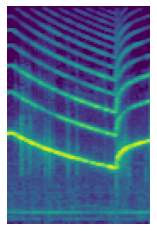

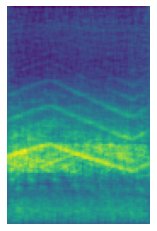

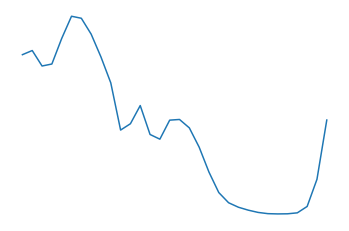

2.280471


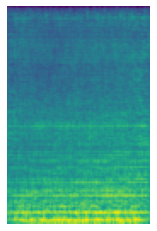

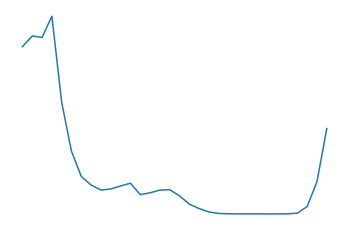

0.8391519


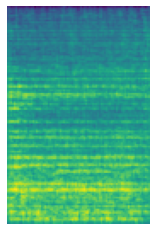

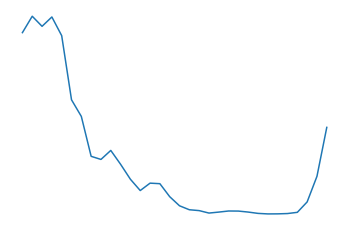

0.59151375


In [17]:
print(dataset.label_list)
ann = np.argmax(Y, axis=1)

j = 0
plt.imshow(X[j].T, origin='lower')
plt.axis('off')
plt.savefig('images/example_decision/X.png', bbox_inches='tight',pad_inches = 0)
plt.show()

prototypes = [44, 0, 7]

#prototypes_class = np.argwhere(model_container.prototypes.classes == ann[j])

for k, ix in enumerate(prototypes):
    plt.imshow(model_container.prototypes.mel_spectrograms[ix].T, origin='lower')
    plt.axis('off')
    plt.savefig('images/example_decision/P_'+ str(k) +'.png', bbox_inches='tight',pad_inches = 0)
    plt.show()
    plt.plot(similarity[j, ix])
    plt.axis('off')
    plt.savefig('images/example_decision/S_'+ str(k) +'.eps', bbox_inches='tight',pad_inches = 0)
    
    plt.show()
    print(ws_similarity[j, ix])


In [18]:
W = model_container.model.get_layer('logits').get_weights()[0]
print(W.shape)

print(W[44,8], W[44,0], W[44,1])
print(W[0,8], W[0,0], W[0,1])
print(W[7,8], W[7,0], W[7,1])


logits = [0, 0, 0]

logits[0] = W[44,8]*ws_similarity[j, 44]+W[0,8]*ws_similarity[j, 0]+W[7,8]*ws_similarity[j, 7]
logits[1] = W[44,0]*ws_similarity[j, 44]+W[0,0]*ws_similarity[j, 0]+W[0,8]*ws_similarity[j, 7]
logits[2] = W[44,1]*ws_similarity[j, 44]+W[0,1]*ws_similarity[j, 0]+W[1,8]*ws_similarity[j, 7]

from scipy.special import softmax

print(softmax(logits))

(50, 10)
0.6122232 -0.4008608 -0.19005048
-0.26289684 0.5477177 -0.3243029
-0.26733205 -0.31736004 0.5881862
[0.74225163 0.14579943 0.11194898]


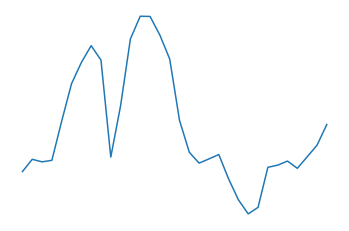

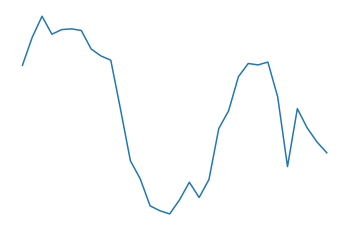

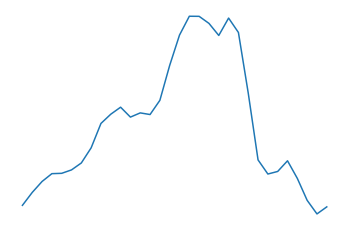

In [20]:
for k, ix in enumerate(prototypes):
    plt.plot(H[ix])
    plt.axis('off')
    plt.savefig('images/example_decision/H_'+ str(k) +'.png', bbox_inches='tight',pad_inches = 0)
    plt.show()